## 0. Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
%matplotlib inline
from sklearn.cluster import KMeans, DBSCAN
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
import os
from IPython.display import clear_output
from mylib.user_func import detect_peaks, twoD_Gaussian, centroid, gauss, bayesian_inference, generate_cmap, analysis_pervskite
import concurrent
from concurrent.futures.process import ProcessPoolExecutor
from itertools import repeat
import pickle

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. Load image and set parameters

In [2]:
# Parameter
model = "Gaussian"       # "CoM" or "Gaussian"
size_peak_search = 20    # pix size of ROI for peak search
size_peak = 20           # pix size of ROI for Gaussian (or CoM) fitting
threshold = 0.4         # Minimun threshold of peak intensity against maximun intensity of image
edge = 1               # region (edge * size_peak) where peak is ignored
n_iter = 6               # Number of loops for Gaussian fit
eps = 3                  # DBSCANのパラメータ
ratio = 50               # Magnification of arrows in displacement map
#calibration = 14.451       # pm/pix(ARM_1K)
#calibration = 7.208       # pm/pix(ARM_2K)
#calibration = 12.102       # pm/pix(spectra_1K)
calibration = 10       # pm/pix(spectra_2K)
display_sigma = 3        # グラフに表示する誤差の大きさ(1: 68%, 2: 95%, 3: 99.7%)
scan_distortion = 0    # スキャン影響による変位決定精度の誤差(1標準偏差) [pm]
input_file = "SrTiO3_1cell_simu_intensity50.dm4"
output_dir = "SrTiO3_50cell_simu_intensity100.dm4"
FWHM = size_peak/2       # Initial value of FWHM for Gaussian fitting

# Import an image
cur_dir = os.getcwd()    # Get filepath of current directory
if os.name == "nt":      # If os is Windows
    data_dir = os.path.dirname(cur_dir) + "\\data"
    ds = hs.load(data_dir + "\\" + input_file)
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data"
    ds = hs.load(data_dir + "//" + input_file)      
s = hs.signals.Signal1D(ds)
ydim, xdim, = s.data.shape
Z = np.flipud(s.data)    # Flip vertically because dm4 has inverse definition of y-axis against matplotlib

## 2. Detect peaks roughly

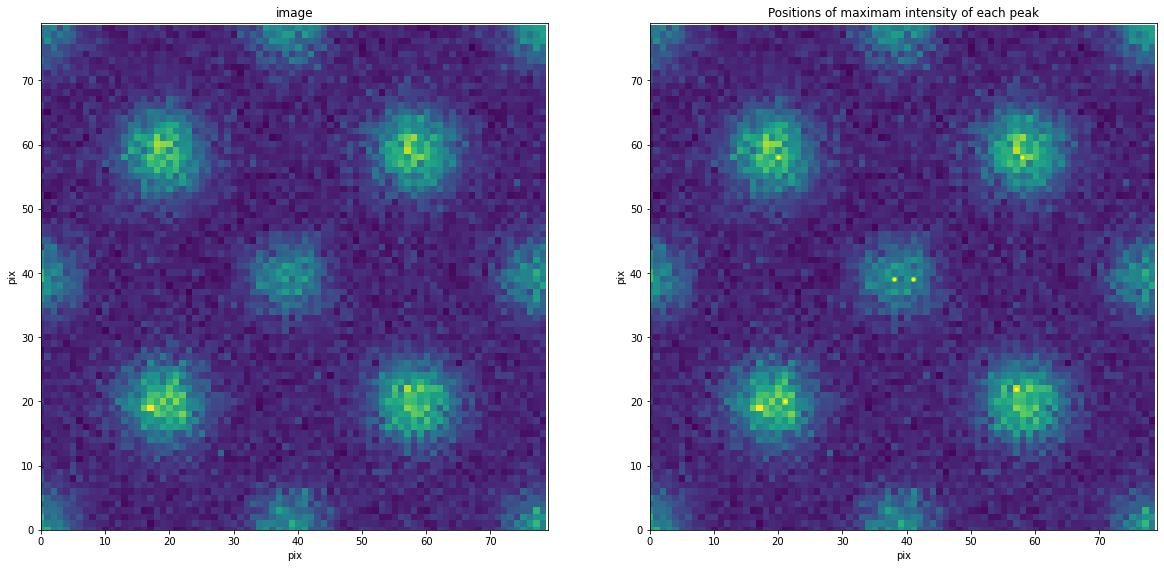

In [3]:
# Search peaks roughly
peaks_maximam = detect_peaks(Z, edge, filter_size=size_peak_search, order=threshold)

# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
ax2.set_title("Positions of maximam intensity of each peak")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
plt.show()

## 3. Clustering Peaks

In [4]:
# Peak detection
min_samples = int((xdim/size_peak)/2*0.6)   # Lower threshold on cluster formation factors in DBSCAN clustering

# Clustering by DBSCAN
peaks_x = peaks_maximam[1]
peaks_y = peaks_maximam[0]
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(np.reshape(peaks_y, [-1, 1]))
labels = dbscan_model.labels_ + 1
col = max(labels)
inlier_peaks_x = peaks_x[~(labels == 0)]
inlier_peaks_y = peaks_y[~(labels == 0)]
cluster_centers = np.array([np.average(peaks_y[(labels == i)]) for i in range(col) ])
labels = labels[~(labels == 0)] - 1

print("Number of peaks = {0}".format(len(peaks_maximam[0])))
print("Number of rows = {0}".format(col))
print("Number of atoms in rows = {0}".format(int(len(labels)/col)))
print("Minimun limit in rows = {0}".format(min_samples*2))

Number of peaks = 6
Number of rows = 3
Number of atoms in rows = 2
Minimun limit in rows = 2


c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 4. Peak fit using simple 2D Gaussian

In [7]:
# Fit 2D gaussian
fit_method = "simple"

decimal = 4    #原子位置の重複を判定する際に、小数点以下第何位までを考慮して判定するか(pix)。初めは0からスタートし、徐々に値を大きくしていくと良い。重複がなくなったら、3以上を入力して次へ

# Calculate atomic positions
peaks = set()
for h in range(len(peaks_y)):
    px = peaks_x[h]
    py = peaks_y[h]
    for i in range(n_iter):
        if model == "CoM": cx,cy = centroid(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))])
        if model == "Gaussian": cx,cy = gauss(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))], size_peak, FWHM)
        px = round(round(px-size_peak/2)+cx, decimal)
        py = round(round(py-size_peak/2)+cy, decimal)
    peaks.add((px, py))

peaks_x = [ x for x, y in peaks ]
peaks_y = [ y for x, y in peaks ]
print("Number of peaks = {0} ⇒ {1}".format(len(peaks_maximam[0]), len(peaks)))

Number of peaks = 6 ⇒ 5


## 5. Check for double count

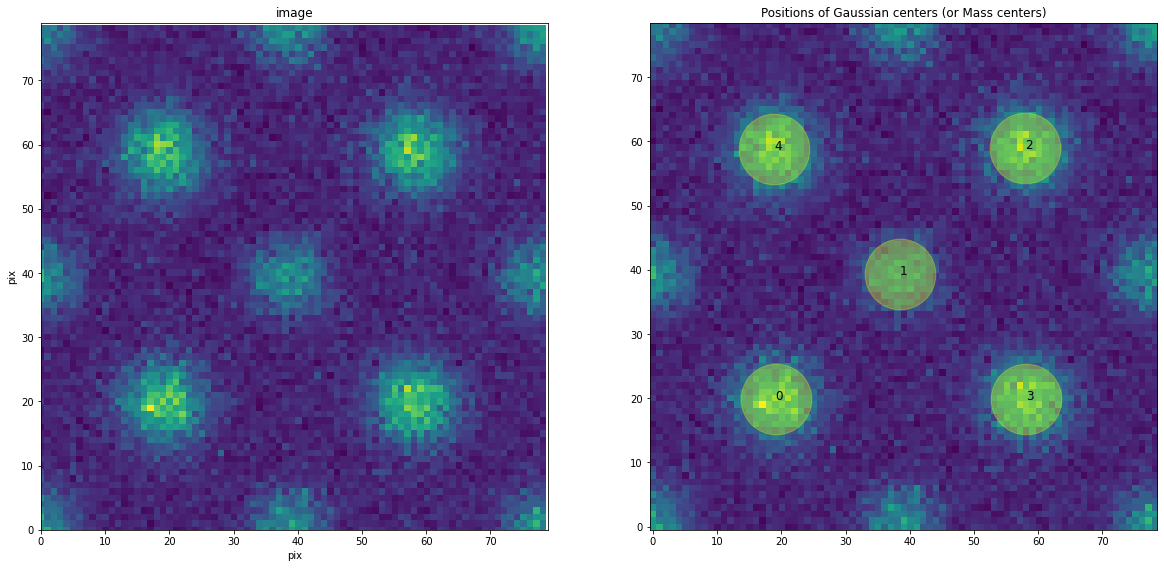

In [12]:
# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5000, c="yellow", marker="o", alpha=0.3)    #sの値を適宜調整して、見やすくすると良い
for i in range(len(peaks_x)):
    ax2.text(peaks_x[i], peaks_y[i], str(i), color="black", fontsize=12)
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
plt.show()

## 6. Peak fit using 2D Gaussian with Bayesian inference

In [13]:
# Parallel processing of bayesian inference (max_workers < num_CPU_core/3)
fit_method = "bayes"
patch = [ Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))] for i in range(len(peaks))]
summary_all = []
with ProcessPoolExecutor(max_workers=5) as executor:
    summary = executor.map(bayesian_inference, repeat(size_peak), patch )
for s in summary:
    summary_all.append(s)

sd_x_bayes = np.zeros_like(peaks_x)
sd_y_bayes = np.zeros_like(peaks_y)
for i in range(len(peaks)):
    sd_x_bayes[i] = summary_all[i].loc["Atom Position (μ)[0]", "sd"]
    sd_y_bayes[i] = summary_all[i].loc["Atom Position (μ)[1]", "sd"]
    peaks_x[i] = summary_all[i].loc["Atom Position (μ)[0]", "mean"] + round(peaks_x[i]-size_peak/2)
    peaks_y[i] = summary_all[i].loc["Atom Position (μ)[1]", "mean"] + round(peaks_y[i]-size_peak/2)

#summary_all

In [ ]:
# Confirmation of main results of bayesian inference
pd.options.display.precision = 3
summary_df = pd.DataFrame([], index=[i for i in range(len(peaks))], columns=["Mean-x [pix]", "Mean-y [pix]", "SD-x [pix]", "SD-y [pix]", "r_hat"])
for i in range(len(peaks)):
    summary_df.loc[i, "Mean-x [pix]"] = summary_all[i].loc["Atom Position (μ)[0]", "mean"]
    summary_df.loc[i, "Mean-y [pix]"] = summary_all[i].loc["Atom Position (μ)[1]", "mean"]
    summary_df.loc[i, "SD-x [pix]"] = summary_all[i].loc["Atom Position (μ)[0]", "sd"]
    summary_df.loc[i, "SD-y [pix]"] = summary_all[i].loc["Atom Position (μ)[1]", "sd"]
    summary_df.loc[i, "r_hat"] = summary_all[i].loc["Atom Position (μ)[0]", "r_hat"]
pd.set_option("display.max_rows", len(summary_df))

summary_df

## 7. Analysis for Pervskite crystal

In [9]:
if fit_method == "simple":
    sd_x_bayes = []
    sd_y_bayes = []

# Analysis for SrTiO3-like pervskite materials
distances, flat_distance_x, flat_distance_y, flat_align_peaks_x, flat_align_peaks_y, flat_sd_x, flat_sd_y, flat_align_sd_x, flat_align_sd_y, flat_center_x, flat_center_y = analysis_pervskite(Z, col, peaks_x, peaks_y, sd_x_bayes, sd_y_bayes, fit_method)

## 8. Make Plots

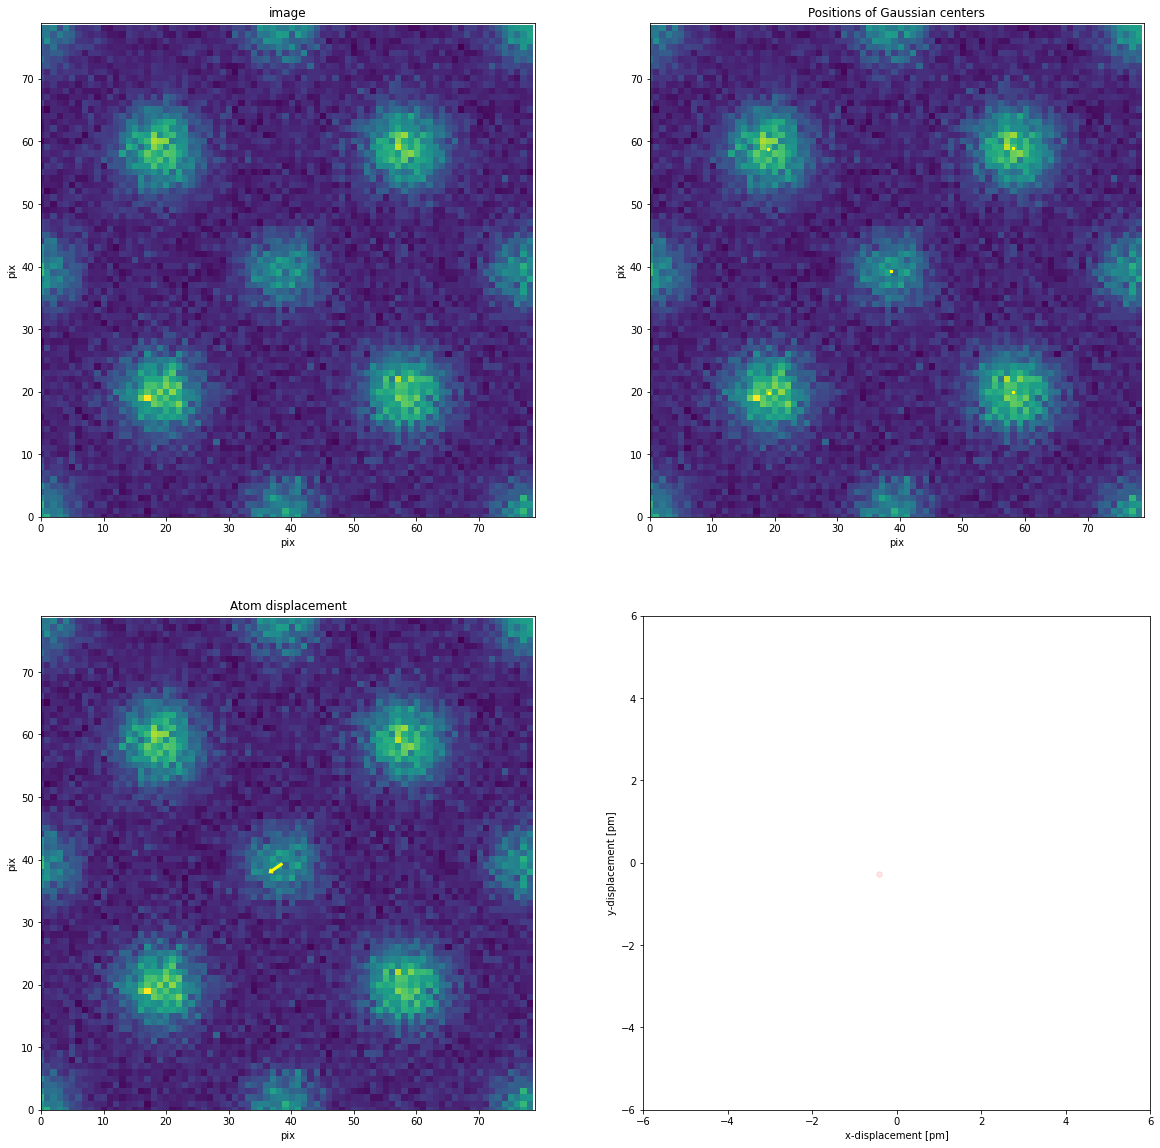

Mean of displacement [pm] = (-0.41, -0.28)
Standard deviation(x, y) of displacement [pm] = (0.00, 0.00)
Standard deviation(kobayashi) of displacement [pm] = (0.00)


In [10]:
# 矢印のカラーを定義
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances[i]/sorted(distances)[-1] for i in range(len(flat_distance_x))])
color = np.where(color>=1, 0.99, color)
color = cm(color)
                  
# Make plots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
if fit_method == "bayes":
    for i in range(len(flat_align_peaks_x)):
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax2.add_patch(patches.Ellipse(xy=(flat_align_peaks_x[i], flat_align_peaks_y[i]), width= flat_align_sd_x[i]*ratio*2*display_sigma, height= flat_align_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
if fit_method == "simple": ax2.set_title("Positions of Gaussian centers")
elif fit_method == "bayes": ax2.set_title("Atomic positions with error")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
ax3.imshow(Z, origin="lower")
for i in range(len(flat_distance_x)):
#    ax3.annotate('', xy=[flat_center_x[i] + flat_distance_x[i]*ratio/2, flat_center_y[i]+flat_distance_y[i]*ratio/2], xytext=[flat_center_x[i]-flat_distance_x[i]*ratio/2, flat_center_y[i]-flat_distance_y[i]*ratio/2], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
#                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    ax3.annotate('', xy=[ flat_center_x[i] + flat_distance_x[i]*ratio, flat_center_y[i] + flat_distance_y[i]*ratio ], xytext=[flat_center_x[i], flat_center_y[i]], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    if fit_method == "bayes":
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width= flat_sd_x[i]*ratio*2*display_sigma, height= flat_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width=(flat_sd_x[i]+scan_distortion/calibration)*2*ratio*display_sigma, height=(flat_sd_y[i]+scan_distortion/calibration)*2*ratio*display_sigma, angle=0, color="yellow", alpha=0.2))
if fit_method == "simple": ax3.set_title("Atom displacement")
elif fit_method == "bayes": ax3.set_title("Atom displacement with error")
ax3.set_xlabel("pix")
ax3.set_ylabel("pix")
ax3.set_xlim(0, xdim)
ax3.set_ylim(0, ydim)
ax4.scatter(np.array(flat_distance_x)*calibration, np.array(flat_distance_y)*calibration, s=30, c="red", marker="o", alpha=0.1)
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
ax4.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_xlim(-6, 6)
ax4.set_ylim(-6, 6)
plt.show()

#変位の平均と標準偏差の表示
std_x = np.std(np.array(flat_distance_x))*calibration
std_y = np.std(np.array(flat_distance_y))*calibration
flat_distance = np.sqrt(np.array(flat_distance_x)**2 + np.array(flat_distance_y)**2)*calibration
kobayashi_std = np.std(flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(flat_distance_x))*calibration, np.mean(np.array(flat_distance_y))*calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(std_x, std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## 9. Save/Load results of Bayesian inference

In [25]:
# save results of Bayesian inference
if os.name == "nt":      # If OS is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir 
    os.mkdir(out_dir)
    out_dir += "\\"
if os.name == "posix":   # If OS is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir
    os.mkdir(out_dir)
    out_dir += "//"

# save files
with open(out_dir + 'summary_all.pkl', 'wb') as f:
    pickle.dump(summary_all, f)
np.save(out_dir + "STEM_image.npy", Z)
np.save(out_dir + "Bayes_peaks-x.npy", peaks_x)
np.save(out_dir + "Bayes_peaks-y.npy", peaks_y)
np.save(out_dir + "Bayes_sd-x.npy", sd_x_bayes)
np.save(out_dir + "Bayes_sd-y.npy", sd_y_bayes)

In [ ]:
# 「Peak fit using simple 2D Gaussian」まで実行 ⇒ このセルを実行 ⇒ 

# load results of Bayesian inference
fit_method = "bayes"
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir + "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir + "//"

# load files
with open(out_dir + 'summary_all.pkl', 'rb') as f:
    summary_all = pickle.load(f)
Z = np.load(out_dir + 'STEM_image.npy')
peaks_x = np.load(out_dir + 'Bayes_peaks-x.npy')
peaks_y = np.load(out_dir + 'Bayes_peaks-y.npy')
sd_x_bayes = np.load(out_dir + 'Bayes_sd-x.npy')
sd_y_bayes = np.load(out_dir + 'Bayes_sd-y.npy')

summary_all

## 10. Test for example atom

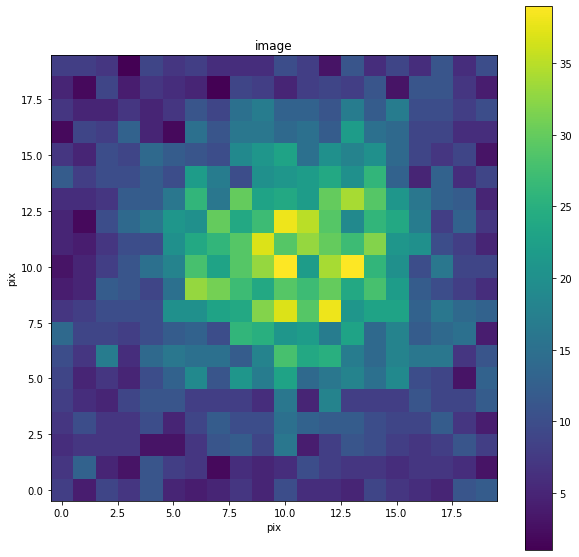

In [30]:
i = 1

#patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]

# Make plots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
im = ax1.imshow(Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))], origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
#ax1.set_xlim(0, size_peak)
#ax1.set_ylim(0, size_peak)
plt.colorbar(im)
plt.show()

In [292]:
#Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)

print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
#patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())

#MCMC Sampling
with model:
    trace = pm.sample(
        draws=1100,
        tune=1000,
        chains=3,
        return_inferencedata=True
    )

Bayesian Inference of atomic position: 2304/4901


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 77 seconds.
INFO:pymc3:Sampling 3 chains for 1_000 tune and 1_100 draw iterations (3_000 + 3_300 draws total) took 77 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Atom Position (μ)[0],10.193,0.081,10.047,10.347,0.001,0.001,4119.0,2717.0,1.0
Atom Position (μ)[1],9.868,0.089,9.702,10.033,0.001,0.001,4436.0,2672.0,1.0
Noise (σ),4.390,0.153,4.107,4.669,0.002,0.002,4483.0,2468.0,1.0
Background Intensity,6.972,0.586,5.838,8.040,0.016,0.011,1401.0,1935.0,1.0
Peak Intensity,42.221,0.853,40.640,43.821,0.014,0.010,3929.0,2508.0,1.0
Cholesky Matrix[0],4.083,0.126,3.849,4.319,0.003,0.002,1636.0,2059.0,1.0
Cholesky Matrix[1],0.078,0.129,-0.150,0.328,0.002,0.002,4471.0,2647.0,1.0
Cholesky Matrix[2],4.414,0.128,4.180,4.663,0.003,0.002,1611.0,1995.0,1.0
"Covariance Matrix[0, 0]",16.688,1.035,14.818,18.653,0.026,0.018,1636.0,2059.0,1.0
"Covariance Matrix[0, 1]",0.320,0.528,-0.626,1.344,0.008,0.008,4490.0,2619.0,1.0


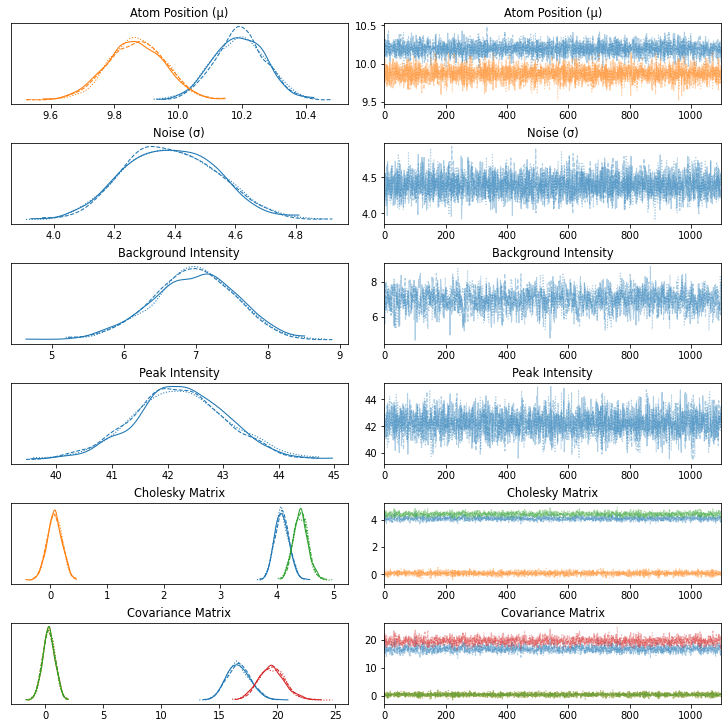

In [293]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(10,10))
az.summary(trace)

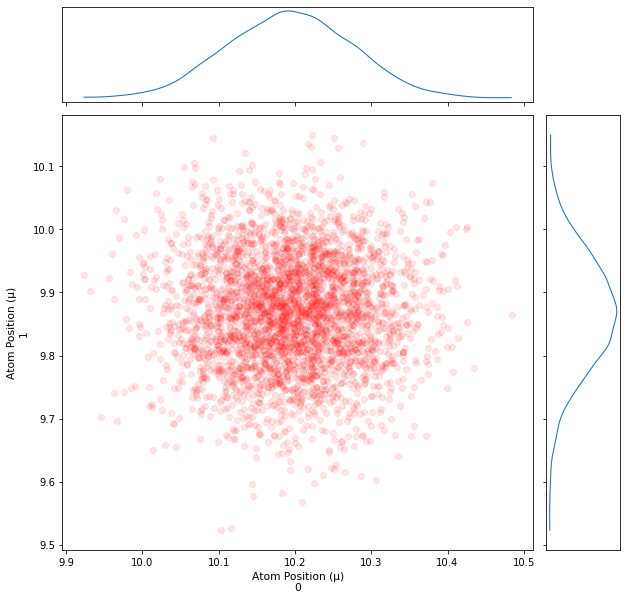

In [297]:
scatter_kwargs = { "c":"red", "marker":"o", "alpha":0.1 }
kde_kwargs = { "contour":False }
az.plot_pair(trace, var_names=["Atom Position (μ)"], kind="scatter", marginals=True, figsize=(10, 10), textsize=10, scatter_kwargs=scatter_kwargs, kde_kwargs=kde_kwargs);


#az.plot_pair(trace, var_names=["Covariance Matrix"], combine_dims={"school"}, kind="kde");

In [ ]:
#Display credible interval
az.plot_posterior(trace, hdi_prob=0.9, backend_kwargs={"constrained_layout":True}, figsize=(10,10), textsize=10);

In [279]:
len(flat_distance_x)

2304